Preprocess Cut Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the provided data file
file_path = '../../Train.csv'
data = pd.read_csv(file_path)

# Convert 'date_time' to datetime format for proper plotting
data['date_time'] = pd.to_datetime(data['date_time'])

# Displaying the first few rows of the dataset to understand its structure
data.head()

date_time is_holiday  air_pollution_index  humidity  wind_speed  \
0 2012-10-02 09:00:00       None                  121        89           2   
1 2012-10-02 10:00:00       None                  178        67           3   
2 2012-10-02 11:00:00       None                  113        66           3   
3 2012-10-02 12:00:00       None                   20        66           3   
4 2012-10-02 13:00:00       None                  281        65           3   

   wind_direction  visibility_in_miles  dew_point  temperature  rain_p_h  \
0             329                    1          1       288.28       0.0   
1             330                    1          1       289.36       0.0   
2             329                    2          2       289.58       0.0   
3             329                    5          5       290.13       0.0   
4             329                    7          7       291.14       0.0   

   snow_p_h  clouds_all weather_type weather_description  traffic_volume  
0       0.0          40       Clouds    scattered clouds            5545  
1       0.0          75       Clouds       broken clouds            4516  
2       0.0          90       Clouds     overcast clouds            4767  
3       0.0          90       Clouds     overcast clouds            5026  
4       0.0          75       Clouds       broken clouds            4918

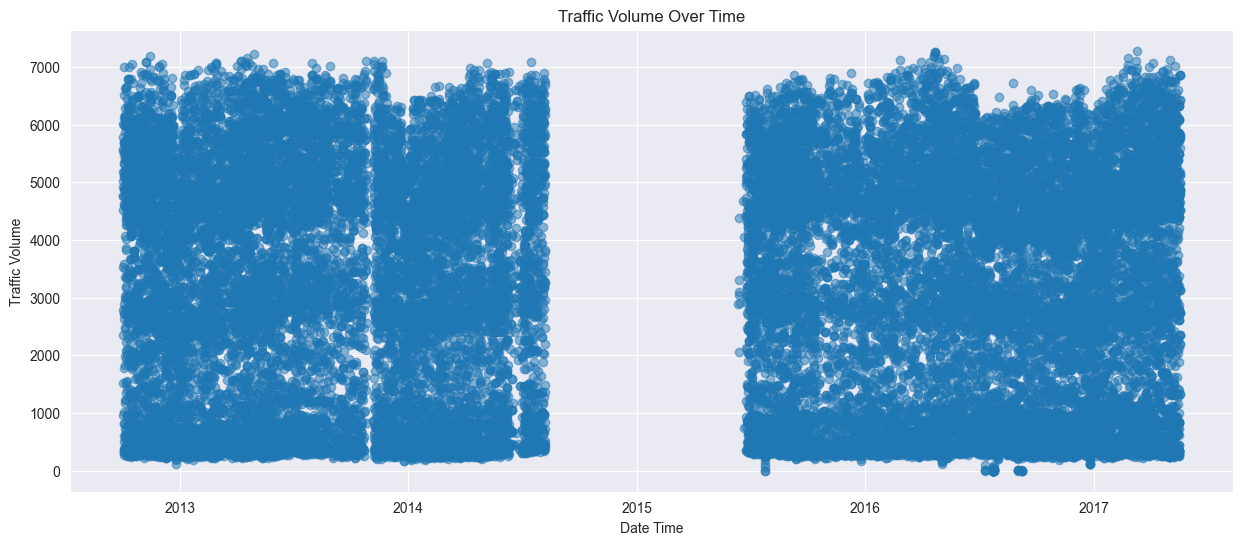

In [2]:
# Creating scatter plot
plt.figure(figsize=(15, 6))

# Scatter plot for 'traffic_volume' against 'date_time'
plt.scatter(data['date_time'], data['traffic_volume'], alpha=0.5)

# Labeling the plot
plt.xlabel('Date Time')
plt.ylabel('Traffic Volume')
plt.title('Traffic Volume Over Time')

# Display the plot
plt.show()

In [3]:
# Convert 'date_time' to datetime format and sort the data
data['date_time'] = pd.to_datetime(data['date_time'])
data = data.sort_values(by='date_time')

# Calculate the difference in time between consecutive entries to find the gap
data['time_diff'] = data['date_time'].diff()

# Identify the largest time gap which would indicate the start of 'C' and end of 'A'
max_gap = data['time_diff'].max()
max_gap_row = data[data['time_diff'] == max_gap]

# Extract the end of 'A' and start of 'C'
end_of_A = max_gap_row['date_time'].iloc[0] - max_gap
start_of_C = max_gap_row['date_time'].iloc[0]


In [4]:
end_of_A, start_of_C

(Timestamp('2014-08-08 01:00:00'), Timestamp('2015-06-11 20:00:00'))

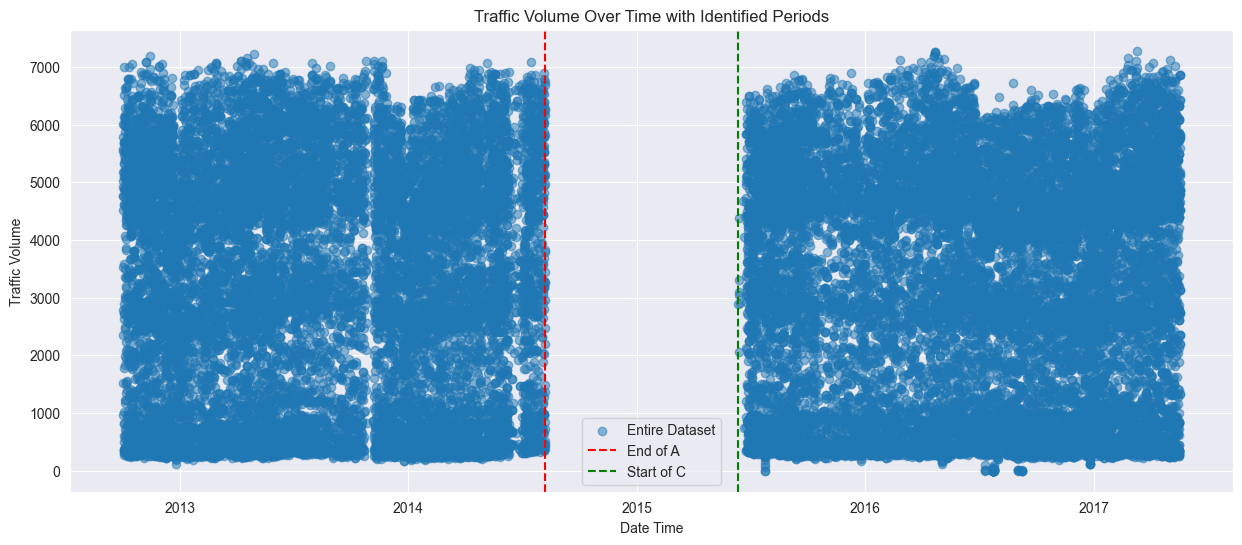

In [5]:
# Creating scatter plots with the correctly identified periods
plt.figure(figsize=(15, 6))

# Scatter plot for the entire dataset
plt.scatter(data['date_time'], data['traffic_volume'], alpha=0.5, label='Entire Dataset')

# Adding the lines for end of 'A' and start of 'C'
plt.axvline(x=end_of_A, color='red', linestyle='--', label='End of A')
plt.axvline(x=start_of_C, color='green', linestyle='--', label='Start of C')

# Labeling the plot
plt.xlabel('Date Time')
plt.ylabel('Traffic Volume')
plt.title('Traffic Volume Over Time with Identified Periods')
plt.legend()

# Display the plot
plt.show()

plt.show()


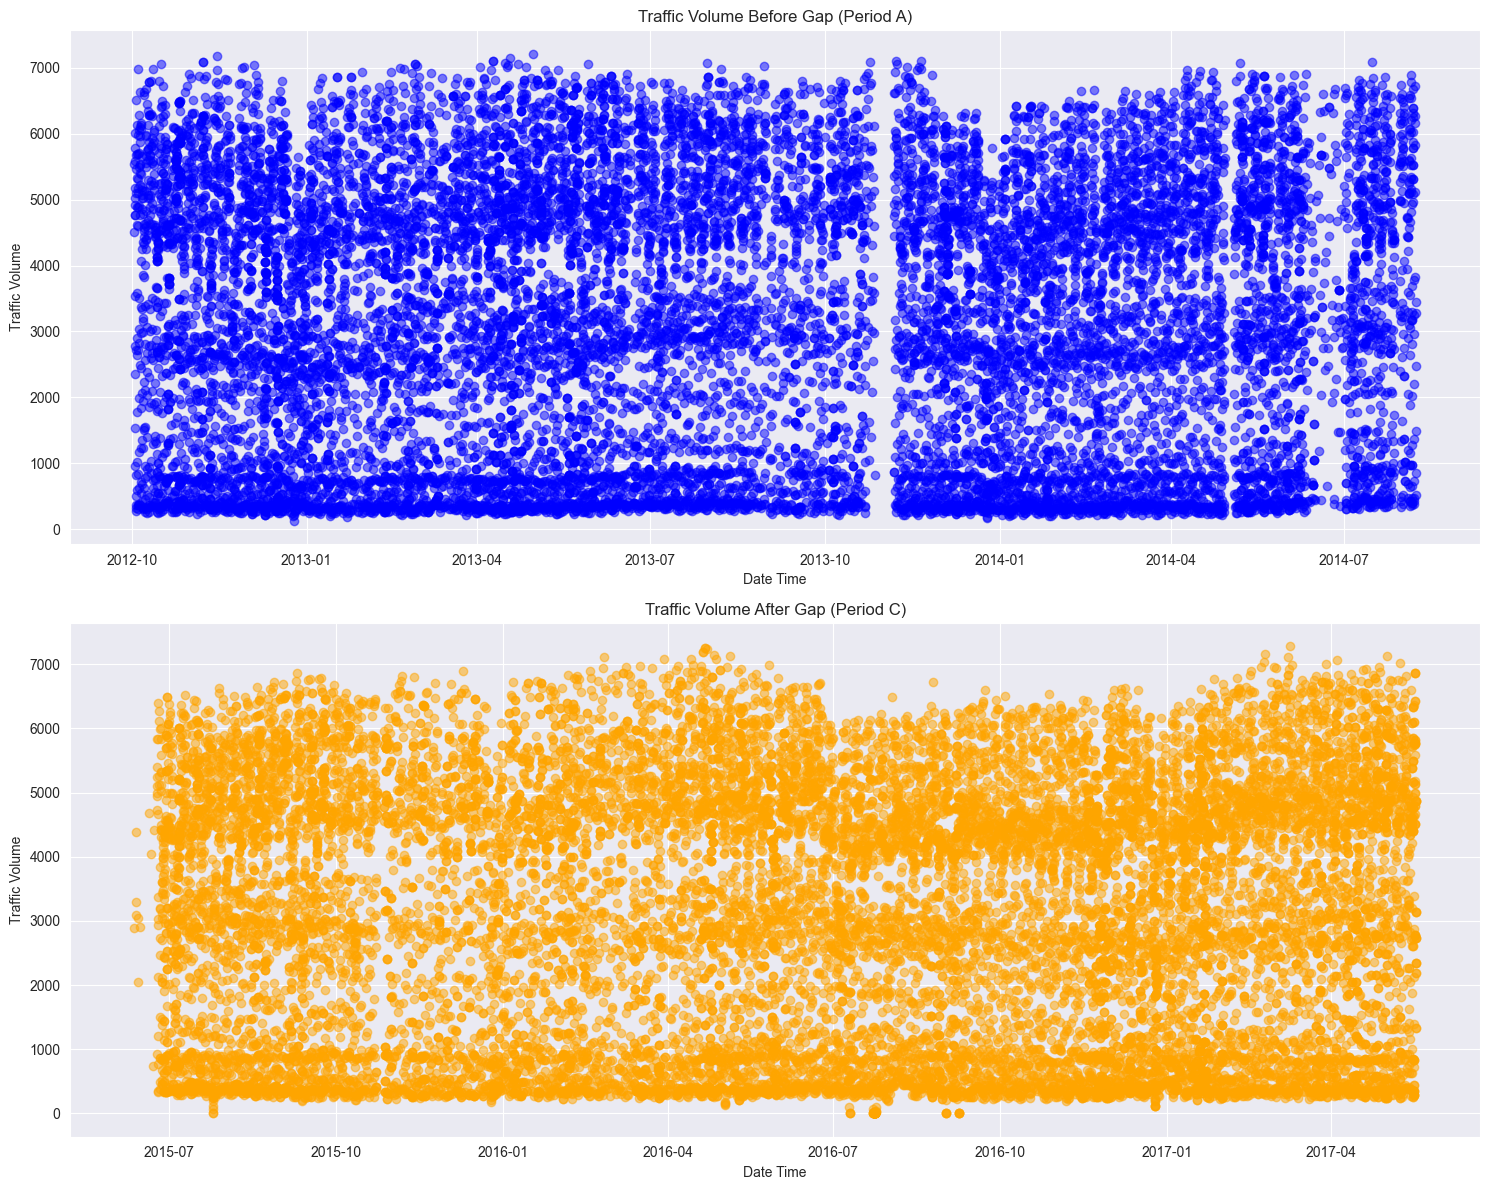

In [6]:
# Filter data for period A and C
data_A = data[data['date_time'] <= end_of_A]
data_C = data[data['date_time'] >= start_of_C]

# Creating scatter plots for periods A and C
fig, ax = plt.subplots(2, 1, figsize=(15, 12))

# Plot for period A
ax[0].scatter(data_A['date_time'], data_A['traffic_volume'], alpha=0.5, color='blue')
ax[0].set_title('Traffic Volume Before Gap (Period A)')
ax[0].set_xlabel('Date Time')
ax[0].set_ylabel('Traffic Volume')

# Plot for period C
ax[1].scatter(data_C['date_time'], data_C['traffic_volume'], alpha=0.5, color='orange')
ax[1].set_title('Traffic Volume After Gap (Period C)')
ax[1].set_xlabel('Date Time')
ax[1].set_ylabel('Traffic Volume')

plt.tight_layout()
plt.show()

In [7]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer, r2_score
import matplotlib.pyplot as plt
import joblib

# Define custom scorer for MAPE
def mape_scorer(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_mask = y_true != 0
    return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100

# Make scorers from custom scoring functions
mape = make_scorer(mape_scorer, greater_is_better=False)

In [8]:
# Load the dataset
df_raw = pd.read_csv('../../Train.csv')

# Convert the 'date_time' column to datetime and sort the dataset
df_raw['date_time'] = pd.to_datetime(df_raw['date_time'])
df_raw.sort_values('date_time', inplace=True)

end_of_A = '2014-08-08 01:00:00'
df_period_A = df_raw[df_raw['date_time'] <= end_of_A]

# Extracting non-numeric columns
non_numeric_cols = ['is_holiday', 'weather_type', 'weather_description']

# Group by 'date_time' and aggregate
agg_funcs = {col: 'mean' for col in df_period_A.columns if col not in non_numeric_cols}
agg_funcs.update({col: lambda x: x.mode()[0] if not x.mode().empty else np.nan for col in non_numeric_cols})
df_aggregated = df_period_A.groupby('date_time').agg(agg_funcs)

# One-hot encode categorical features
df = pd.get_dummies(df_aggregated, columns=non_numeric_cols, drop_first=True)

# Add hour from the index
df['hour'] = df.index.hour

# Feature engineering: create lagged and rolling features
target = 'traffic_volume'
for i in range(1, 4):
    df[f'traffic_volume_lag_{i}'] = df[target].shift(i)
df['traffic_volume_rolling_mean'] = df[target].rolling(window=3).mean().shift(1)
df['traffic_volume_rolling_std'] = df[target].rolling(window=3).std().shift(1)


# Remove rows with NaN values resulting from lagged features
df.dropna(inplace=True)

# Split the dataset into features and the target
X = df.drop(target, axis=1)
y = df[target]

# Save 'date_time' for later use
date_time = df['date_time']

# Drop 'date_time' column before scaling
df = df.drop(columns=['date_time'])

# Scale the numerical features
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

# Convert scaled data back to DataFrame and add 'date_time' column back
df_scaled = pd.DataFrame(df_scaled, columns=[col for col in df.columns if col != 'date_time'])
df_scaled['date_time'] = date_time.values

# Split the data into train and test sets
total_samples = df_scaled.shape[0]
split_index = int(total_samples * 0.9)

X_train = df_scaled.iloc[:split_index].drop(columns=['date_time'])
y_train = y.iloc[:split_index]
X_test = df_scaled.iloc[split_index:].drop(columns=['date_time'])
y_test = y.iloc[split_index:]

Period C

In [9]:
# Initialize the XGBoost regressor
xgboost_model = xgb.XGBRegressor(objective='reg:squarederror')

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.5, 1],
    'reg_alpha': [0, 0.1, 1, 10]
}

# Scoring parameters
scoring = {
    'RMSE': 'neg_root_mean_squared_error',
    'MSE': 'neg_mean_squared_error',
    'MAE': 'neg_mean_absolute_error',
    'MAPE': mape
}

# Time series cross-validator
tscv = TimeSeriesSplit(n_splits=5)

# GridSearchCV
grid_search = GridSearchCV(
    estimator=xgboost_model,
    param_grid=param_grid,
    scoring=scoring,
    refit='RMSE',
    cv=tscv,
    verbose=1
)

# Fit the grid search to the scaled data
grid_search.fit(X_train, y_train)

# Best parameters and model
best_parameters_grid = grid_search.best_params_
print(f"Best parameters found with GridSearchCV: {best_parameters_grid}")
best_model_grid = grid_search.best_estimator_

# Save the best model
joblib.dump(best_model_grid, 'best_xgboost_model_gridsearch_period_C.joblib')

Fitting 5 folds for each of 3888 candidates, totalling 19440 fits
Best parameters found with GridSearchCV: {'colsample_bytree': 1.0, 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'reg_alpha': 0, 'subsample': 1.0}


['best_xgboost_model_gridsearch_period_C.joblib']

In [10]:
y_train_pred_grid = best_model_grid.predict(X_train)
train_metrics_grid = {
    'RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred_grid)),
    'MSE': mean_squared_error(y_train, y_train_pred_grid),
    'MAE': mean_absolute_error(y_train, y_train_pred_grid),
    'MAPE': mape_scorer(y_train, y_train_pred_grid),
    'R2': r2_score(y_train, y_train_pred_grid)
}

# Evaluate metrics on the validation set
y_val_pred_grid = best_model_grid.predict(X_test)
val_metrics_grid = {
    'RMSE': np.sqrt(mean_squared_error(y_test, y_val_pred_grid)),
    'MSE': mean_squared_error(y_test, y_val_pred_grid),
    'MAE': mean_absolute_error(y_test, y_val_pred_grid),
    'MAPE': mape_scorer(y_test, y_val_pred_grid),
    'R2': r2_score(y_test, y_val_pred_grid)
}

# Print and compare metrics for GridSearchCV
print("\nMetrics with GridSearchCV:")
print("Training Set Metrics:")
print(train_metrics_grid)
print("\nValidation Set Metrics:")
print(val_metrics_grid)


Metrics with GridSearchCV:
Training Set Metrics:
{'RMSE': 8.584885752083819, 'MSE': 73.70026337633176, 'MAE': 6.505298299381419, 'MAPE': 0.36272047670404794, 'R2': 0.9999818172239773}

Validation Set Metrics:
{'RMSE': 10.04124697984441, 'MSE': 100.82664091023449, 'MAE': 7.704006277399955, 'MAPE': 0.38317194682016015, 'R2': 0.999975292544725}


In [11]:
df.columns

Index(['air_pollution_index', 'humidity', 'wind_speed', 'wind_direction',
       'visibility_in_miles', 'dew_point', 'temperature', 'rain_p_h',
       'snow_p_h', 'clouds_all', 'traffic_volume', 'is_holiday_Columbus Day',
       'is_holiday_Independence Day', 'is_holiday_Labor Day',
       'is_holiday_Martin Luther King Jr Day', 'is_holiday_Memorial Day',
       'is_holiday_New Years Day', 'is_holiday_None', 'is_holiday_State Fair',
       'is_holiday_Thanksgiving Day', 'is_holiday_Veterans Day',
       'is_holiday_Washingtons Birthday', 'weather_type_Clouds',
       'weather_type_Drizzle', 'weather_type_Fog', 'weather_type_Haze',
       'weather_type_Mist', 'weather_type_Rain', 'weather_type_Snow',
       'weather_type_Squall', 'weather_type_Thunderstorm',
       'weather_description_Sky is Clear', 'weather_description_broken clouds',
       'weather_description_drizzle', 'weather_description_few clouds',
       'weather_description_fog', 'weather_description_haze',
       'weather_de

In [12]:
df

air_pollution_index  humidity  wind_speed  \
date_time                                                        
2012-10-02 12:00:00                 20.0      66.0         3.0   
2012-10-02 13:00:00                281.0      65.0         3.0   
2012-10-02 14:00:00                 23.0      65.0         3.0   
2012-10-02 15:00:00                184.0      64.0         3.0   
2012-10-02 16:00:00                167.0      64.0         3.0   
...                                  ...       ...         ...   
2014-08-07 21:00:00                 30.0      75.0         3.0   
2014-08-07 22:00:00                160.0      72.0         3.0   
2014-08-07 23:00:00                120.0      70.0         3.0   
2014-08-08 00:00:00                137.0      69.0         3.0   
2014-08-08 01:00:00                 61.0      66.0         3.0   

                     wind_direction  visibility_in_miles  dew_point  \
date_time                                                             
2012-10-02 12:00:00           329.0                  5.0        5.0   
2012-10-02 13:00:00           329.0                  7.0        7.0   
2012-10-02 14:00:00           328.0                  6.0        6.0   
2012-10-02 15:00:00           328.0                  7.0        7.0   
2012-10-02 16:00:00           327.0                  7.0        7.0   
...                             ...                  ...        ...   
2014-08-07 21:00:00           333.0                  6.0        6.0   
2014-08-07 22:00:00           337.0                  5.0        5.0   
2014-08-07 23:00:00           335.0                  3.0        3.0   
2014-08-08 00:00:00           333.0                  5.0        5.0   
2014-08-08 01:00:00           330.0                  8.0        8.0   

                     temperature  rain_p_h  snow_p_h  clouds_all  ...  \
date_time                                                         ...   
2012-10-02 12:00:00       290.13       0.0       0.0        90.0  ...   
2012-10-02 13:00:00       291.14       0.0       0.0        75.0  ...   
2012-10-02 14:00:00       291.72       0.0       0.0         1.0  ...   
2012-10-02 15:00:00       293.17       0.0       0.0         1.0  ...   
2012-10-02 16:00:00       293.86       0.0       0.0         1.0  ...   
...                          ...       ...       ...         ...  ...   
2014-08-07 21:00:00       295.46       0.0       0.0         1.0  ...   
2014-08-07 22:00:00       294.69       0.0       0.0         1.0  ...   
2014-08-07 23:00:00       294.48       0.0       0.0        90.0  ...   
2014-08-08 00:00:00       293.45       0.0       0.0        40.0  ...   
2014-08-08 01:00:00       292.38       0.0       0.0         1.0  ...   

                     weather_description_thunderstorm with heavy rain  \
date_time                                                               
2012-10-02 12:00:00                                                 0   
2012-10-02 13:00:00                                                 0   
2012-10-02 14:00:00                                                 0   
2012-10-02 15:00:00                                                 0   
2012-10-02 16:00:00                                                 0   
...                                                               ...   
2014-08-07 21:00:00                                                 0   
2014-08-07 22:00:00                                                 0   
2014-08-07 23:00:00                                                 0   
2014-08-08 00:00:00                                                 0   
2014-08-08 01:00:00                                                 0   

                     weather_description_thunderstorm with light drizzle  \
date_time                                                                  
2012-10-02 12:00:00                                                  0     
2012-10-02 13:00:00                                                  0     
2012-10-02 14:00:00               

In [13]:
df.columns

Index(['air_pollution_index', 'humidity', 'wind_speed', 'wind_direction',
       'visibility_in_miles', 'dew_point', 'temperature', 'rain_p_h',
       'snow_p_h', 'clouds_all', 'traffic_volume', 'is_holiday_Columbus Day',
       'is_holiday_Independence Day', 'is_holiday_Labor Day',
       'is_holiday_Martin Luther King Jr Day', 'is_holiday_Memorial Day',
       'is_holiday_New Years Day', 'is_holiday_None', 'is_holiday_State Fair',
       'is_holiday_Thanksgiving Day', 'is_holiday_Veterans Day',
       'is_holiday_Washingtons Birthday', 'weather_type_Clouds',
       'weather_type_Drizzle', 'weather_type_Fog', 'weather_type_Haze',
       'weather_type_Mist', 'weather_type_Rain', 'weather_type_Snow',
       'weather_type_Squall', 'weather_type_Thunderstorm',
       'weather_description_Sky is Clear', 'weather_description_broken clouds',
       'weather_description_drizzle', 'weather_description_few clouds',
       'weather_description_fog', 'weather_description_haze',
       'weather_de

In [14]:
df = pd.concat([date_time, df], axis=1)

In [15]:
# Reset index of df to align with X_test if necessary
df = df.reset_index(drop=True)

# Initialize DataFrame for dynamic forecasting
df_dynamic_forecast = X_test.copy()
df_dynamic_forecast['forecasted_traffic_volume'] = np.nan

# Ensure forecast_steps is not larger than the length of X_test
forecast_steps = min(720, len(X_test))

In [16]:
# Function to update the lagged features with the new prediction
def update_lagged_features(df, new_prediction, max_lags=3):
    for i in range(max_lags-1, 0, -1):
        df[f'traffic_volume_lag_{i+1}'] = df[f'traffic_volume_lag_{i}']
    df['traffic_volume_lag_1'] = new_prediction

for i in range(forecast_steps):
    # Predict the traffic volume for the next time step
    current_prediction = best_model_grid.predict(df_dynamic_forecast.iloc[i:i+1].drop(columns=['forecasted_traffic_volume']))[0]
    df_dynamic_forecast.at[df_dynamic_forecast.index[i], 'forecasted_traffic_volume'] = current_prediction

    # Update lagged features with the new prediction for the next iteration
    if i + 1 < forecast_steps:
        update_lagged_features(df_dynamic_forecast.iloc[i + 1], current_prediction)

C:\Users\Nadim Pramono\AppData\Local\Temp\ipykernel_37432\3179905858.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'traffic_volume_lag_{i+1}'] = df[f'traffic_volume_lag_{i}']
C:\Users\Nadim Pramono\AppData\Local\Temp\ipykernel_37432\3179905858.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['traffic_volume_lag_1'] = new_prediction
C:\Users\Nadim Pramono\AppData\Local\Temp\ipykernel_37432\3179905858.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

In [17]:
# Initialize the DataFrame
test_date_times = df['date_time'][split_index:].reset_index(drop=True)

df_result = pd.DataFrame({
    'date_time': test_date_times,
    'actual_traffic_volume': y_test.reset_index(drop=True),
    'lag_1': np.nan,
    'lag_2': np.nan,
    'lag_3': np.nan,
    'forecasted_traffic_volume': df_dynamic_forecast['forecasted_traffic_volume'].reset_index(drop=True)
})

# Set the initial lagged values from the historical data
df_result.loc[0, 'lag_1'] = df.loc[split_index - 1, 'traffic_volume']
df_result.loc[0, 'lag_2'] = df.loc[split_index - 2, 'traffic_volume']
df_result.loc[0, 'lag_3'] = df.loc[split_index - 3, 'traffic_volume']

# Update the lagged values with the forecasted values in each step
for i in range(1, len(df_result)):
    df_result.loc[i, 'lag_1'] = df_result.loc[i - 1, 'forecasted_traffic_volume']
    df_result.loc[i, 'lag_2'] = df_result.loc[i - 1, 'lag_1']
    df_result.loc[i, 'lag_3'] = df_result.loc[i - 1, 'lag_2']

# Display the DataFrame
print(df_result.head(forecast_steps))

              date_time  actual_traffic_volume        lag_1        lag_2  \
0   2014-05-17 17:00:00                 4906.0  4893.000000  5028.000000   
1   2014-05-17 18:00:00                 4258.0  4909.330566  4893.000000   
2   2014-05-17 19:00:00                 3699.0  4266.175293  4909.330566   
3   2014-05-17 20:00:00                 3317.0  3681.280029  4266.175293   
4   2014-05-17 21:00:00                 3226.0  3305.553955  3681.280029   
..                  ...                    ...          ...          ...   
715 2014-07-05 04:00:00                  319.0  1445.429443  2686.277588   
716 2014-07-05 05:00:00                  623.0   320.138550  1445.429443   
717 2014-07-05 06:00:00                 1118.0   628.561584   320.138550   
718 2014-07-05 07:00:00                 1452.0  1107.046143   628.561584   
719 2014-07-05 08:00:00                 2019.0  1445.736084  1107.046143   

           lag_3  forecasted_traffic_volume  
0    5308.000000                4909.3305

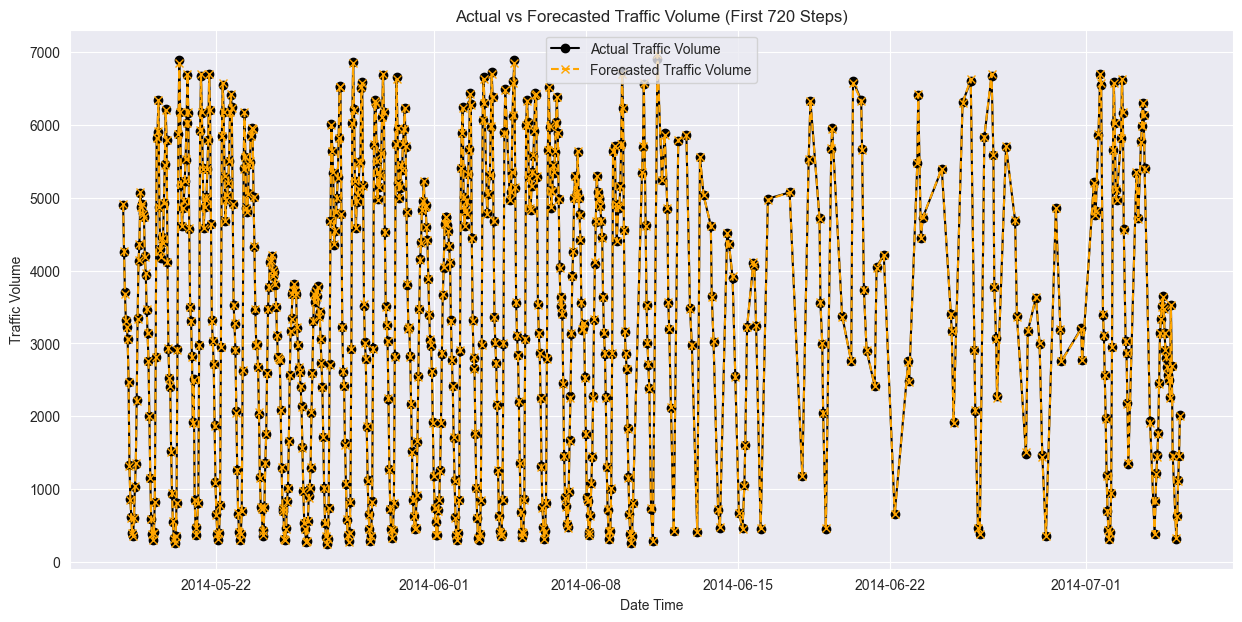

In [18]:
import matplotlib.pyplot as plt

# Select the steps for plotting
df_plot = df_result.head(forecast_steps)

# Plotting the actual vs. forecasted traffic volumes
plt.figure(figsize=(15, 7))
plt.plot(df_plot['date_time'], df_plot['actual_traffic_volume'], label='Actual Traffic Volume', color='black', marker='o')
plt.plot(df_plot['date_time'], df_plot['forecasted_traffic_volume'], label='Forecasted Traffic Volume', color='orange', linestyle='--', marker='x')

# Adding labels and title
plt.xlabel('Date Time')
plt.ylabel('Traffic Volume')
plt.title('Actual vs Forecasted Traffic Volume (First 720 Steps)')
plt.legend()

# Display the plot
plt.show()

In [19]:
df_result.tail()

date_time  actual_traffic_volume  lag_1  lag_2  lag_3  \
1385 2014-08-07 21:00:00                 3274.0    NaN    NaN    NaN   
1386 2014-08-07 22:00:00                 2479.0    NaN    NaN    NaN   
1387 2014-08-07 23:00:00                 1491.0    NaN    NaN    NaN   
1388 2014-08-08 00:00:00                  848.0    NaN    NaN    NaN   
1389 2014-08-08 01:00:00                  516.0    NaN    NaN    NaN   

      forecasted_traffic_volume  
1385                        NaN  
1386                        NaN  
1387                        NaN  
1388                        NaN  
1389                        NaN

In [20]:
df_result.dropna(inplace=True)

In [21]:
actual_values = df_result['actual_traffic_volume']
new_forecasted_values = df_result['forecasted_traffic_volume']

# Evaluate metrics on the training set
y_train_pred_grid = best_model_grid.predict(X_train)
train_metrics_grid = {
    'RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred_grid)),
    'MSE': mean_squared_error(y_train, y_train_pred_grid),
    'MAE': mean_absolute_error(y_train, y_train_pred_grid),
    'MAPE': mape_scorer(y_train, y_train_pred_grid),
    'R2': r2_score(y_train, y_train_pred_grid)  # R2 score for training set
}

# Calculate the metrics for forecasted values
forecast_metrics = {
    'RMSE': np.sqrt(mean_squared_error(actual_values, new_forecasted_values)),
    'MSE': mean_squared_error(actual_values, new_forecasted_values),
    'MAE': mean_absolute_error(actual_values, new_forecasted_values),
    'MAPE': mape_scorer(actual_values, new_forecasted_values),
    'R2': r2_score(actual_values, new_forecasted_values)  # R2 score for forecast
}

# Print the metrics
print("\nMetrics for Train Values:")
print(train_metrics_grid)
print("\nMetrics for Forecasted Values:")
print(forecast_metrics)



Metrics for Train Values:
{'RMSE': 8.584885752083819, 'MSE': 73.70026337633176, 'MAE': 6.505298299381419, 'MAPE': 0.36272047670404794, 'R2': 0.9999818172239773}

Metrics for Forecasted Values:
{'RMSE': 9.775093817019709, 'MSE': 95.55245913153695, 'MAE': 7.536552895439995, 'MAPE': 0.3722858145868561, 'R2': 0.9999760111096944}
